# Model

In [33]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [153]:
import numpy as np
from scipy.sparse import csr_matrix
from scipy.sparse import lil_matrix
import matplotlib.pyplot as plt
import pandas as pd
import math
import pickle
import time
import datetime
import random

In [154]:
random.seed(42)
np.random.seed(42)

## Data Preprocessing

In [155]:
recs = pd.read_csv('data/pruned.csv')

In [156]:
recs.head()

,app_id,helpful,funny,date,is_recommended,hours,user_id,review_id
0,534380,0,0,2022-10-08,True,40.6,10531,22
1,42700,6,2,2019-10-19,False,5.9,185293,27
2,602960,0,0,2022-01-05,True,41.9,319249,58
3,976730,0,0,2021-11-25,False,21.1,747545,67
4,1091500,2,0,2022-10-30,True,18.1,2113544,127


In [157]:
USED_COLS = ['app_id', 'is_recommended', 'user_id']

recs = recs[USED_COLS]
recs.head()

,app_id,is_recommended,user_id
0,534380,True,10531
1,42700,False,185293
2,602960,True,319249
3,976730,False,747545
4,1091500,True,2113544


In [158]:
item_data = pd.read_csv('data/games.csv')
item_data.head()

,app_id,title,date_release,win,mac,linux,rating,positive_ratio,user_reviews,price_final,price_original,discount,steam_deck
0,10090,Call of Duty: World at War,2008-11-18,True,False,False,Very Positive,92,37039,19.99,19.99,0.0,True
1,13500,Prince of Persia: Warrior Within™,2008-11-21,True,False,False,Very Positive,84,2199,9.99,9.99,0.0,True
2,22364,BRINK: Agents of Change,2011-08-03,True,False,False,Positive,85,21,2.99,2.99,0.0,True
3,113020,Monaco: What's Yours Is Mine,2013-04-24,True,True,True,Very Positive,92,3722,14.99,14.99,0.0,True
4,226560,Escape Dead Island,2014-11-18,True,False,False,Mixed,61,873,14.99,14.99,0.0,True


In [159]:
titles = item_data[['app_id', 'title']]

## Data Class

In [160]:
from RecData import RecData

In [161]:
class Metrics:
    def rmse(self, predictions):
        return math.sqrt(sum((prediction - true_rating)**2 for _, _, prediction, true_rating in predictions)/len(predictions))

In [162]:
rec_data = RecData()
rec_data.create_from_dataframe(recs)
rec_data.set_titles(titles)

In [163]:
train_data, test = rec_data.leave_k_out_split()
train_data, val = train_data.leave_k_out_split()

## Simple Model

In [164]:
def item_averages(M):
    # Division by 0 -> no data for item -> predict average of all items
    with np.errstate(invalid='ignore'):
        # Take item averages
        averages = (np.sum(M.toarray(), axis=0)/np.count_nonzero(M.toarray(), axis=0))

        # Fill na with averages over all items
        averages = np.nan_to_num(averages, nan=np.nanmean(averages))
    return averages

In [165]:
class AveragePredictor:
    """Simple model which always predicts the average value of an item."""
    def fit(self, M):
        self._averages = item_averages(M)
        
    def predict(self, pairs):
        """Parameters:
        pairs - user-item pairs to predict"""
        predictions = []
        for user, item in pairs:
            predictions.append((user, item, self._averages[item]))

        return predictions

In [166]:
predictor = AveragePredictor()
predictor.fit(train_data.get_matrix())

In [167]:
predictions = predictor.predict([(user, item) for user, item, _ in val])
predictions = [prediction + (test[i][2],) for i, prediction in enumerate(predictions)]
metrics = Metrics()
metrics.rmse(predictions)

0.4035456108732124

## SVD

In [196]:
from SVD import SVDPredictor

Below is testings a fit on all data

Epoch 0/Training error: 1.8456070071013584/Validation error: 1.852211998953922/Time: 38.65 seconds
Epoch 1/Training error: 0.852764552721043/Validation error: 0.8696366767290956/Time: 38.72 seconds
Epoch 2/Training error: 0.5139281096964413/Validation error: 0.5157755909137542/Time: 37.13 seconds
Epoch 3/Training error: 0.42743878892232434/Validation error: 0.4317819718047689/Time: 37.05 seconds
Epoch 4/Training error: 0.3919355129887587/Validation error: 0.39885828682706814/Time: 37.2 seconds
Epoch 5/Training error: 0.3732579383539253/Validation error: 0.38191658811009366/Time: 37.28 seconds
Epoch 6/Training error: 0.3616549514734005/Validation error: 0.37189834006355027/Time: 41.65 seconds
Epoch 7/Training error: 0.3532857124939885/Validation error: 0.3651969973825731/Time: 37.87 seconds
Epoch 8/Training error: 0.346431266895533/Validation error: 0.36051183789983865/Time: 38.41 seconds
Epoch 9/Training error: 0.3399378658105228/Validation error: 0.35703690993315723/Time: 37.74 second

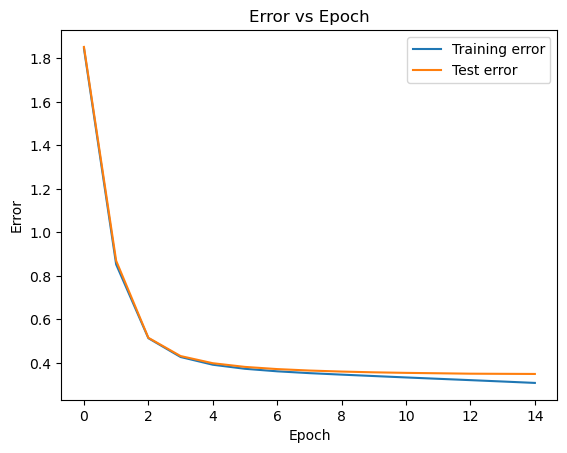

Test rmse 0.34951497819791627
Saving model...
Done saving model.


In [197]:
EPOCHS = 15

random.seed(42)
np.random.seed(42)

# Fit and predict with svd
svd_predictor = SVDPredictor(train_data.get_num_users(), train_data.get_num_items(), k=25, epochs=EPOCHS, learning_rate=0.01, C=0.005)
svd_predictor.fit(train_data.get_matrix(), validation_set=val)

# Plot error
errors = svd_predictor.get_train_errors()
val_errors = svd_predictor.get_val_errors()
plt.plot(range(EPOCHS), errors, label='Training error')
plt.plot(range(EPOCHS), val_errors, label='Test error')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Error vs Epoch')
plt.legend()
plt.show()

# Compute rmse
predictions = svd_predictor.predict([(user, item) for user, item, _ in val])
predictions = [prediction + (val[i][2],) for i, prediction in enumerate(predictions)]
metrics = Metrics()
rmse = metrics.rmse(predictions)
print("Test rmse", rmse)

model_dir = model_dir = "saved_models/{}-{}-{}-{}-{}-{}_{}".format(*(time.localtime()[:6] + (round(rmse, 4), ))).replace(".", "-") + ".pkl" 

# Ensure file exists
file = open(model_dir, 'a')
file.close()

print("Saving model...")
with open(model_dir, 'wb') as file:
    pickle.dump([svd_predictor, rec_data, train_data, val, test], file)
print("Done saving model.")

In [198]:
# Test top-n list for user 0
top_n = svd_predictor.top_n(0)
print(top_n)
print([train_data.index_to_title(index) for _, index in top_n])

[(2.1819324946173424, 1031), (2.175950239401213, 456), (2.1597915922401136, 168), (2.1587838625232516, 384), (2.1540966984197594, 511), (2.152019688930803, 1901), (2.1505927591827234, 544), (2.150259429118729, 1771), (2.149153270143035, 2057), (2.1491011424275293, 761)]
['Dungeon Warfare 2', 'Choice of Robots', 'Thief™ II: The Metal Age', 'Hexcells Infinite', 'Controller Companion', 'Symphony of War: The Nephilim Saga', 'Aviary Attorney', 'Against the Storm', 'The Case of the Golden Idol', 'Glass Masquerade']


In [199]:
# User 0 true top n list
true_top = rec_data.top_n(0, 100)
print([rec_data.index_to_title(index) for _, index in true_top])

['Grand Theft Auto IV: The Complete Edition', 'Fallout: New Vegas', 'Dying Light', '7 Days to Die', 'American Truck Simulator', 'RimWorld', 'DARK SOULS™ II: Scholar of the First Sin', 'Dead Island Definitive Edition', 'DRAGON BALL XENOVERSE 2', 'Satisfactory', 'Dying Light 2 Stay Human', "Assassin's Creed® Origins", 'Phasmophobia', 'Halo: The Master Chief Collection', 'Timberborn', 'Orcs Must Die! 3']


Testing loading the model below

In [200]:
rec_data.search_title('1330')

[]

In [201]:
prefs = [(606, 1), (1628, 1), (391, 0), (1330, 0), (500, 0), (709, 1), (840, 0), (58, 1), (456, 1), (153, 0), (158, 0), (1160, 0), (761, 0),
                              (1771, 0), (544, 0), (312, 0), (277, 0)]
print([(index, rec_data.index_to_title(index), pref) for index, pref in prefs])
prefs = rec_data.create_prefs(prefs)    

[(606, 'Stardew Valley', 1), (1628, 'The Sims™ 4', 1), (391, 'Mortal Kombat X', 0), (1330, 'Mortal Kombat\xa011', 0), (500, 'Total War: WARHAMMER', 0), (709, 'UNO', 1), (840, 'MONOPOLY® PLUS', 0), (58, 'SPORE™', 1), (456, 'Choice of Robots', 1), (153, 'Infested Planet', 0), (158, 'Gunpoint', 0), (1160, 'Cosmoteer: Starship Architect & Commander', 0), (761, 'Glass Masquerade', 0), (1771, 'Against the Storm', 0), (544, 'Aviary Attorney', 0), (312, 'Grand Theft Auto V', 0), (277, 'Rust', 0)]


In [202]:
svd_predictor._partial_batch_size = 0
start_time = time.time()
svd_predictor.partial_fit(prefs)
print("Completed partial fit in", time.time() - start_time, "seconds")

top_n = svd_predictor.top_n(train_data.get_matrix().shape[0])
print([(r, train_data.index_to_title(index)) for r, index in top_n])

Epoch 0/Training error: 0.3083331703218864/Time: 1.39 seconds
Epoch 1/Training error: 0.3083328926339789/Time: 1.38 seconds
Epoch 2/Training error: 0.30833282414094726/Time: 1.27 seconds
Epoch 3/Training error: 0.3083328050624232/Time: 1.41 seconds
Epoch 4/Training error: 0.3083327843542073/Time: 1.37 seconds
Epoch 5/Training error: 0.3083327693992622/Time: 1.4 seconds
Epoch 6/Training error: 0.3083328307163822/Time: 1.36 seconds
Epoch 7/Training error: 0.30833273293506774/Time: 1.41 seconds
Epoch 8/Training error: 0.30833276879885846/Time: 1.45 seconds
Epoch 9/Training error: 0.30833269941733893/Time: 1.56 seconds
Epoch 10/Training error: 0.30833268922486395/Time: 1.46 seconds
Epoch 11/Training error: 0.30833267354297084/Time: 1.36 seconds
Epoch 12/Training error: 0.30833267959416827/Time: 1.46 seconds
Epoch 13/Training error: 0.3083327658660967/Time: 1.5 seconds
Epoch 14/Training error: 0.3083326704275515/Time: 1.35 seconds
Completed partial fit in 21.16813373565674 seconds
[(1.48151

In [149]:
MODEL_DIR = 'saved_models/2023-6-19-14-39-44_0-3619.pkl'

saved = None
with open(MODEL_DIR, 'rb') as file:
    saved = pickle.load(file)
    
svd_predictor, rec_data, train_data, val, test = saved